# ANALYSE DES DONNEES


In [1]:
from pyspark.sql import SparkSession


spark = SparkSession.builder.appName("ham or spam").getOrCreate() 

df = spark.read.csv("./DataSetEmails/DataSet_Emails.csv", header=True, inferSchema=True,multiLine=True,escape='"')



In [2]:
df.printSchema()

df.show()

root
 |-- _c0: integer (nullable = true)
 |-- message_id: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- label_text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- message: string (nullable = true)
 |-- date: date (nullable = true)

+---+----------+--------------------+-----+----------+--------------------+--------------------+----------+
|_c0|message_id|                text|label|label_text|             subject|             message|      date|
+---+----------+--------------------+-----+----------+--------------------+--------------------+----------+
|  0|     33214|any software just...|    1|      spam|any software just...|understanding oem...|2005-06-18|
|  1|     11929|perspective on fe...|    0|       ham|perspective on fe...|19 th , 2 : 00 pm...|2001-06-19|
|  2|     19784|wanted to try ci ...|    1|      spam|wanted to try ci ...|viagra at $ 1 . 1...|2004-09-11|
|  3|      2209|enron / hpl actua...|  

In [3]:
from pyspark.sql import functions as f

df.select("message_id").agg(
    f.count("message_id")
).show()
df = df.dropDuplicates()

df.select("message_id").agg(
    f.count("message_id")
).show()

df = df.dropna()

df.select("message_id").agg(
    f.count("message_id")
).show()

+-----------------+
|count(message_id)|
+-----------------+
|            31716|
+-----------------+

+-----------------+
|count(message_id)|
+-----------------+
|            31716|
+-----------------+

+-----------------+
|count(message_id)|
+-----------------+
|            31148|
+-----------------+



In [4]:
df.show()

+----+----------+--------------------+-----+----------+--------------------+--------------------+----------+
| _c0|message_id|                text|label|label_text|             subject|             message|      date|
+----+----------+--------------------+-----+----------+--------------------+--------------------+----------+
|  85|     28759|thank you for you...|    0|       ham|thank you for you...|thank you for cha...|2001-08-13|
| 107|     32256|re : account than...|    1|      spam|        re : account|thank you very mu...|2005-03-21|
| 292|     28739|fw : cec natural ...|    0|       ham|fw : cec natural ...|fyi , kim .\n- - ...|2001-08-03|
| 317|     18440|deep penetration ...|    1|      spam|deep penetration ...|download undergro...|2004-03-02|
| 427|      2106|calpine monthly n...|    0|       ham|calpine monthly n...|>\naimee , i am s...|2000-11-27|
| 870|     25411|ggood for you hel...|    1|      spam|       ggood for you|hello , welcome t...|2005-06-23|
|1067|      8777|re

In [5]:
df.groupBy('label').agg(f.count('label')).show()

+-----+------------+
|label|count(label)|
+-----+------------+
|    1|       15645|
|    0|       15503|
+-----+------------+



In [6]:
df_spam = df.filter(f.col('label') == 1)
df_ham = df.filter(f.col('label') == 0)

In [7]:
spam_text = df_spam.agg(
    f.concat_ws(" ", f.collect_list("text")).alias("all_text")
).collect()[0]["all_text"]



In [8]:
ham_text = df_ham.agg(
    f.concat_ws(" ", f.collect_list("text")).alias("all_text")
).collect()[0]["all_text"]

In [9]:
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


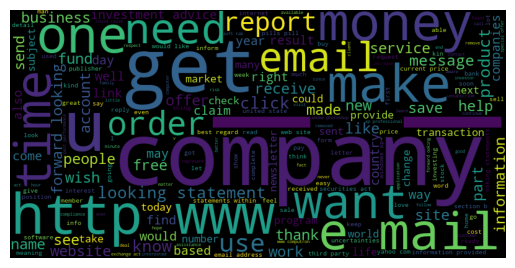

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc_spam = WordCloud(width=800, height=400, stopwords=stop_words).generate(spam_text)
plt.imshow(wc_spam); plt.axis('off') ; plt.show()


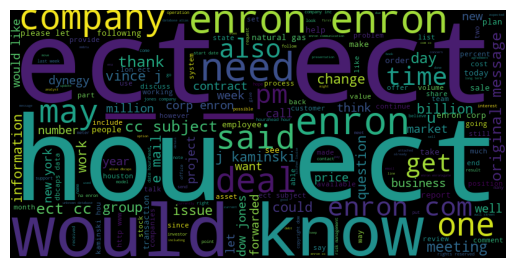

In [11]:
wc_ham = WordCloud(width=800, height=400, stopwords=stop_words).generate(ham_text)
plt.imshow(wc_ham); plt.axis('off'); plt.show() 

In [12]:
print(ham_text)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



# pretraitement 


In [13]:
df_normalized = df.withColumn(
    'text',
    f.lower(f.regexp_replace(f.regexp_replace("text", '[^a-zA-Z ]', "")," +", " " ))
    )

In [14]:
df_normalized.show()

+----+----------+--------------------+-----+----------+--------------------+--------------------+----------+
| _c0|message_id|                text|label|label_text|             subject|             message|      date|
+----+----------+--------------------+-----+----------+--------------------+--------------------+----------+
|  85|     28759|thank you for you...|    0|       ham|thank you for you...|thank you for cha...|2001-08-13|
| 107|     32256|re account thank ...|    1|      spam|        re : account|thank you very mu...|2005-03-21|
| 292|     28739|fw cec natural ga...|    0|       ham|fw : cec natural ...|fyi , kim .\n- - ...|2001-08-03|
| 317|     18440|deep penetration ...|    1|      spam|deep penetration ...|download undergro...|2004-03-02|
| 427|      2106|calpine monthly n...|    0|       ham|calpine monthly n...|>\naimee , i am s...|2000-11-27|
| 870|     25411|ggood for you hel...|    1|      spam|       ggood for you|hello , welcome t...|2005-06-23|
|1067|      8777|re

In [15]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol="text", outputCol="tokens")

df_tokenized = tokenizer.transform(df_normalized)

In [16]:
df_tokenized.show(truncate=False)

+----+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# stemming or lemmatization 


In [17]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def stem_tokens(tokens_list):
    if tokens_list is None:
        return []
    return [stemmer.stem(w) for w in tokens_list]

stem_tokens_udf = f.udf(stem_tokens, f.ArrayType(f.StringType()))

df_stemmed = df_tokenized.withColumn("stemmed_tokens",stem_tokens_udf("tokens"))



In [18]:
df_stemmed.show(truncate=False)

+----+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [19]:
from pyspark.ml.feature import HashingTF, IDF

hashing_tf = HashingTF(
    inputCol="stemmed_tokens",
    outputCol="raw_features",
    numFeatures=20000
)

df_tf = hashing_tf.transform(df_stemmed)

idf = IDF(inputCol="raw_features", outputCol="tf_idf_features")

tf_idf_model = idf.fit(df_tf)
tf_idf_df = tf_idf_model.transform(df_tf)


In [20]:
tf_idf_df.select("tokens", "tf_idf_features").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# drop les colonnes non necessaire

In [ ]:
from pyspark.ml.classification import RandomForestClassificationModel, LinearSVC, LogisticRegression, GBTClassificationModel

